In [4]:
import os
import numpy as np
import pandas as pd
import tempfile

import pandapower as pp
import pandapower.networks as nw
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import pandapower.plotting as pplt
import matplotlib.pyplot as plt
from pandapower.plotting.plotly import pf_res_plotly

#creating our net
net = nw.create_cigre_network_mv()

#Creating buses and trafos

pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14 - 0.63MVA', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11 - 0.4MVA',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')

#print(net)

#ax = pplt.simple_plot(net, show_plot = False)
#clc = pplt.create_line_collection(net, color ="g", linewidth = 3.,use_bus_geodata=(True))
#pplt.draw_collections([clc], ax=ax)
#plt.show()

#Adding CS at rated power (6.6 kW)


max_line_loading=100

max_vm_pu= 1.1

min_vm_pu= 0.9

In [5]:
#importing the active and reactive power of loads from excel
df_active = pd.read_csv('active_power_time_series_ev_load.csv')
df_reactive = pd.read_csv('reactive_power_time_series_ev_load.csv')
# create the data source from
ds_active = DFData(df_active)
ds_reactive = DFData(df_reactive)

def timeseries_example(output_dir):
    
    #defing the time step
    n_timesteps = 24
    
    # 3. create controllers (to control P values of the load) ds_p is for active power and ds_q for reactive power
    create_controllers(net, ds_active, ds_reactive)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps) 
    
    
load_index=net.load.index
load_name=net.load.name
def create_controllers(net,ds_active,ds_reactive):
    for i in range(len(load_index)):
        ConstControl(net, element='load', variable='p_mw', element_index=load_index[i],
                 data_source=ds_active, profile_name=load_name[i])
        ConstControl(net, element='load', variable='q_mvar', element_index=load_index[i],
                 data_source=ds_reactive, profile_name=load_name[i])

def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    ow.log_variable('res_trafo','loading_percent')
    return ow


In [6]:
output_dir = os.path.join("time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: time_series_ev


100%|██████████| 24/24 [00:01<00:00, 18.70it/s]


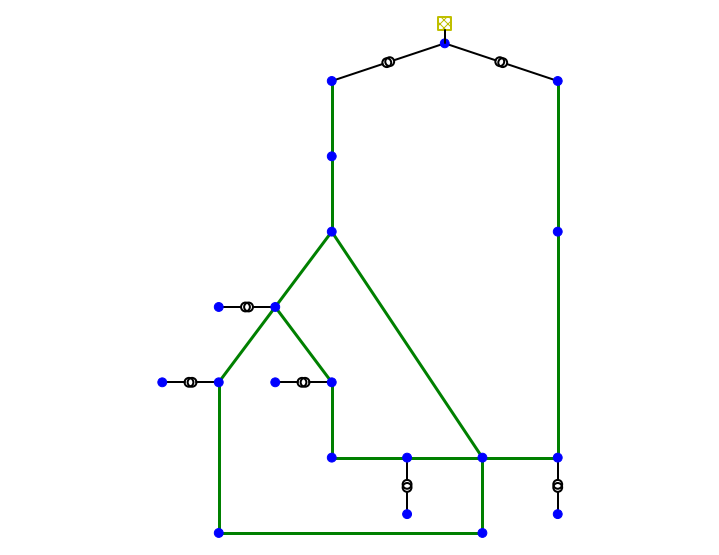

In [7]:
#ev_loads
#adding ev's

for i in range (1,314):
    l=str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
#Bus CS 11 (0.4 MVA) - trafo id: 3
for i in range (314,402):
    l=str(i)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

#Bus CS 5 (0.4 MVA) - trafo id: 4
for i in range (402,412):
    l=str(i)
    pp.create_load(net, bus=17, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

ax = pplt.simple_plot(net, show_plot = False)
clc = pplt.create_line_collection(net, color ="g", linewidth = 3.,use_bus_geodata=(True))
pplt.draw_collections([clc], ax=ax)
plt.show()
#pp.runpp(net)

In [8]:
print("-----------------------------    STEP 1.2    -----------------------")

#net = nw.create_cigre_network_mv()

vmax = 1.05
vmin = 0.95
max_ll = 100

lines = net.line.index 
N = list()

for l in lines:
    net.line.loc[l,"in_service"] = False
    pp.runpp(net)
    
    
    if net.res_bus.vm_pu.max() > vmax or net.res_bus.vm_pu.min() < vmin or net.res_line.loading_percent.max() > max_ll:
        N.append(l)
        print("critical line")
        print(l)
        net.res_bus.vm_pu
        net.res_bus.vm_pu
        net.res_line.loading_percent
        
    net.line.loc[l,"in_service"] = True
    
#ax = pplt.simple_plot(net, show_plot = False)
#clc = pplt.create_line_collection(net, N, color ="r", linewidth = 3.,use_bus_geodata=(True))
#pplt.draw_collections([clc], ax=ax)
#plt.show()
print(N)

-----------------------------    STEP 1.2    -----------------------
critical line
0
critical line
1
critical line
2
critical line
3
critical line
4
critical line
5
critical line
6
critical line
7
critical line
8
critical line
9
critical line
12
critical line
13
critical line
14
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14]


In [9]:
print("-----------------------------    STEP 1.2    -----------------------")

net = nw.create_cigre_network_mv()

vmax = 1.05
vmin = 0.95
max_ll = 100

lines = net.line.index 
N = list()

for l in lines:
    net.line.loc[l,"in_service"] = False
    pp.runpp(net)
    
    
    if net.res_bus.vm_pu.max() > vmax or net.res_bus.vm_pu.min() < vmin or net.res_line.loading_percent.max() > max_ll:
        N.append(l)
        print("critical line")
        print(l)
        net.res_bus.vm_pu
        net.res_bus.vm_pu
        net.res_line.loading_percent
        
    net.line.loc[l,"in_service"] = True
    
#ax = pplt.simple_plot(net, show_plot = False)
#clc = pplt.create_line_collection(net, N, color ="r", linewidth = 3.,use_bus_geodata=(True))
#pplt.draw_collections([clc], ax=ax)
#plt.show()
print(N)

-----------------------------    STEP 1.2    -----------------------
critical line
3
critical line
4
critical line
5
critical line
7
critical line
8
critical line
10
critical line
11
critical line
12
critical line
13
critical line
14
[3, 4, 5, 7, 8, 10, 11, 12, 13, 14]


TypeError: can only concatenate str (not "int") to str